In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diluition/dillution-Test2.png
/kaggle/input/dilution-test/dillution-1.png
/kaggle/input/dilution-test/dillution.png
/kaggle/input/odimgs/clear2.png
/kaggle/input/odimgs/clear.png
/kaggle/input/odimgs/s2.png
/kaggle/input/odimgs/s1.png


In [2]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu
from skimage import data, filters, measure, morphology
import numpy as np 
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage.io import imread, imshow

In [3]:
import cv2

originalImg = cv2.imread('../input/diluition/dillution-Test2.png')
originalImg = cv2.cvtColor(originalImg, cv2.COLOR_BGR2RGB)
greyImg = cv2.cvtColor(originalImg, cv2.COLOR_RGB2GRAY)


### Original Image

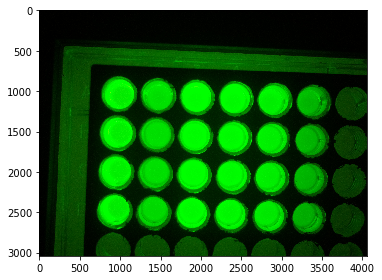

In [4]:
imshow(originalImg)

### Gray Scale Image

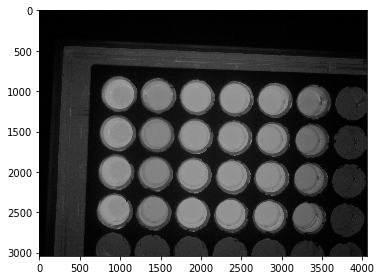

In [5]:
imshow(greyImg)

## Perspective Transform

In [6]:
pts1 = np.float32(
        [[753, 773], # top left
         [3649, 889], # top right
         [657, 2733], # bottom left
         [3565, 2833]] # bottom right
)

pts2 = np.float32(
        [[0,0], # top left
         [2945,0], # top right
         [0,1945], # bottom left
         [2945,1945]] # bottom right
         )

matrix = cv2.getPerspectiveTransform(pts1,pts2)
pResult = cv2.warpPerspective(greyImg, matrix, (2945,1945)) # set size image based on pts2 (w = 500 h = 600)

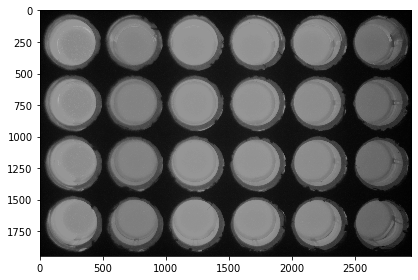

In [7]:
imshow(pResult)

## Gamma Correction

In [8]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [9]:
gammaIMG = adjust_gamma(pResult, gamma=0.7)

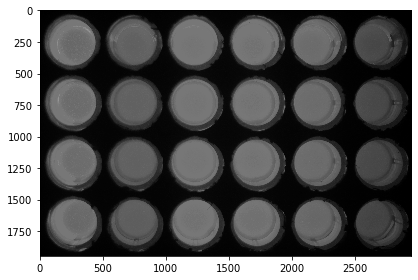

In [10]:
imshow(gammaIMG)

## Well Plate Cropping

In [11]:
sample1=gammaIMG

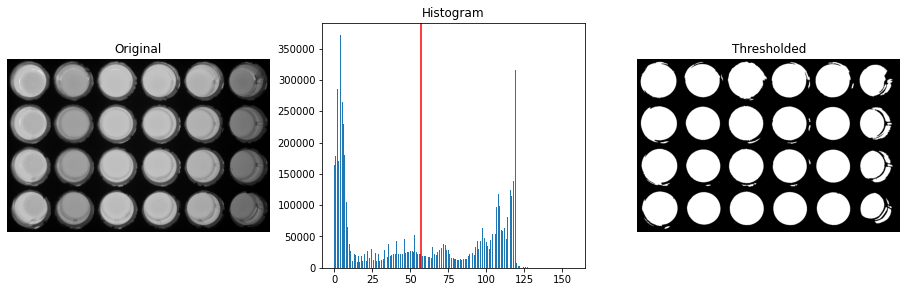

In [12]:
image = sample1
thresh = threshold_otsu(image)
binary = image > thresh
binary = morphology.remove_small_objects(binary, 400)
binary = morphology.remove_small_holes(binary, 400)
labels = measure.label(binary)
fig, axes = plt.subplots(ncols=3, figsize=(16, 4.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()


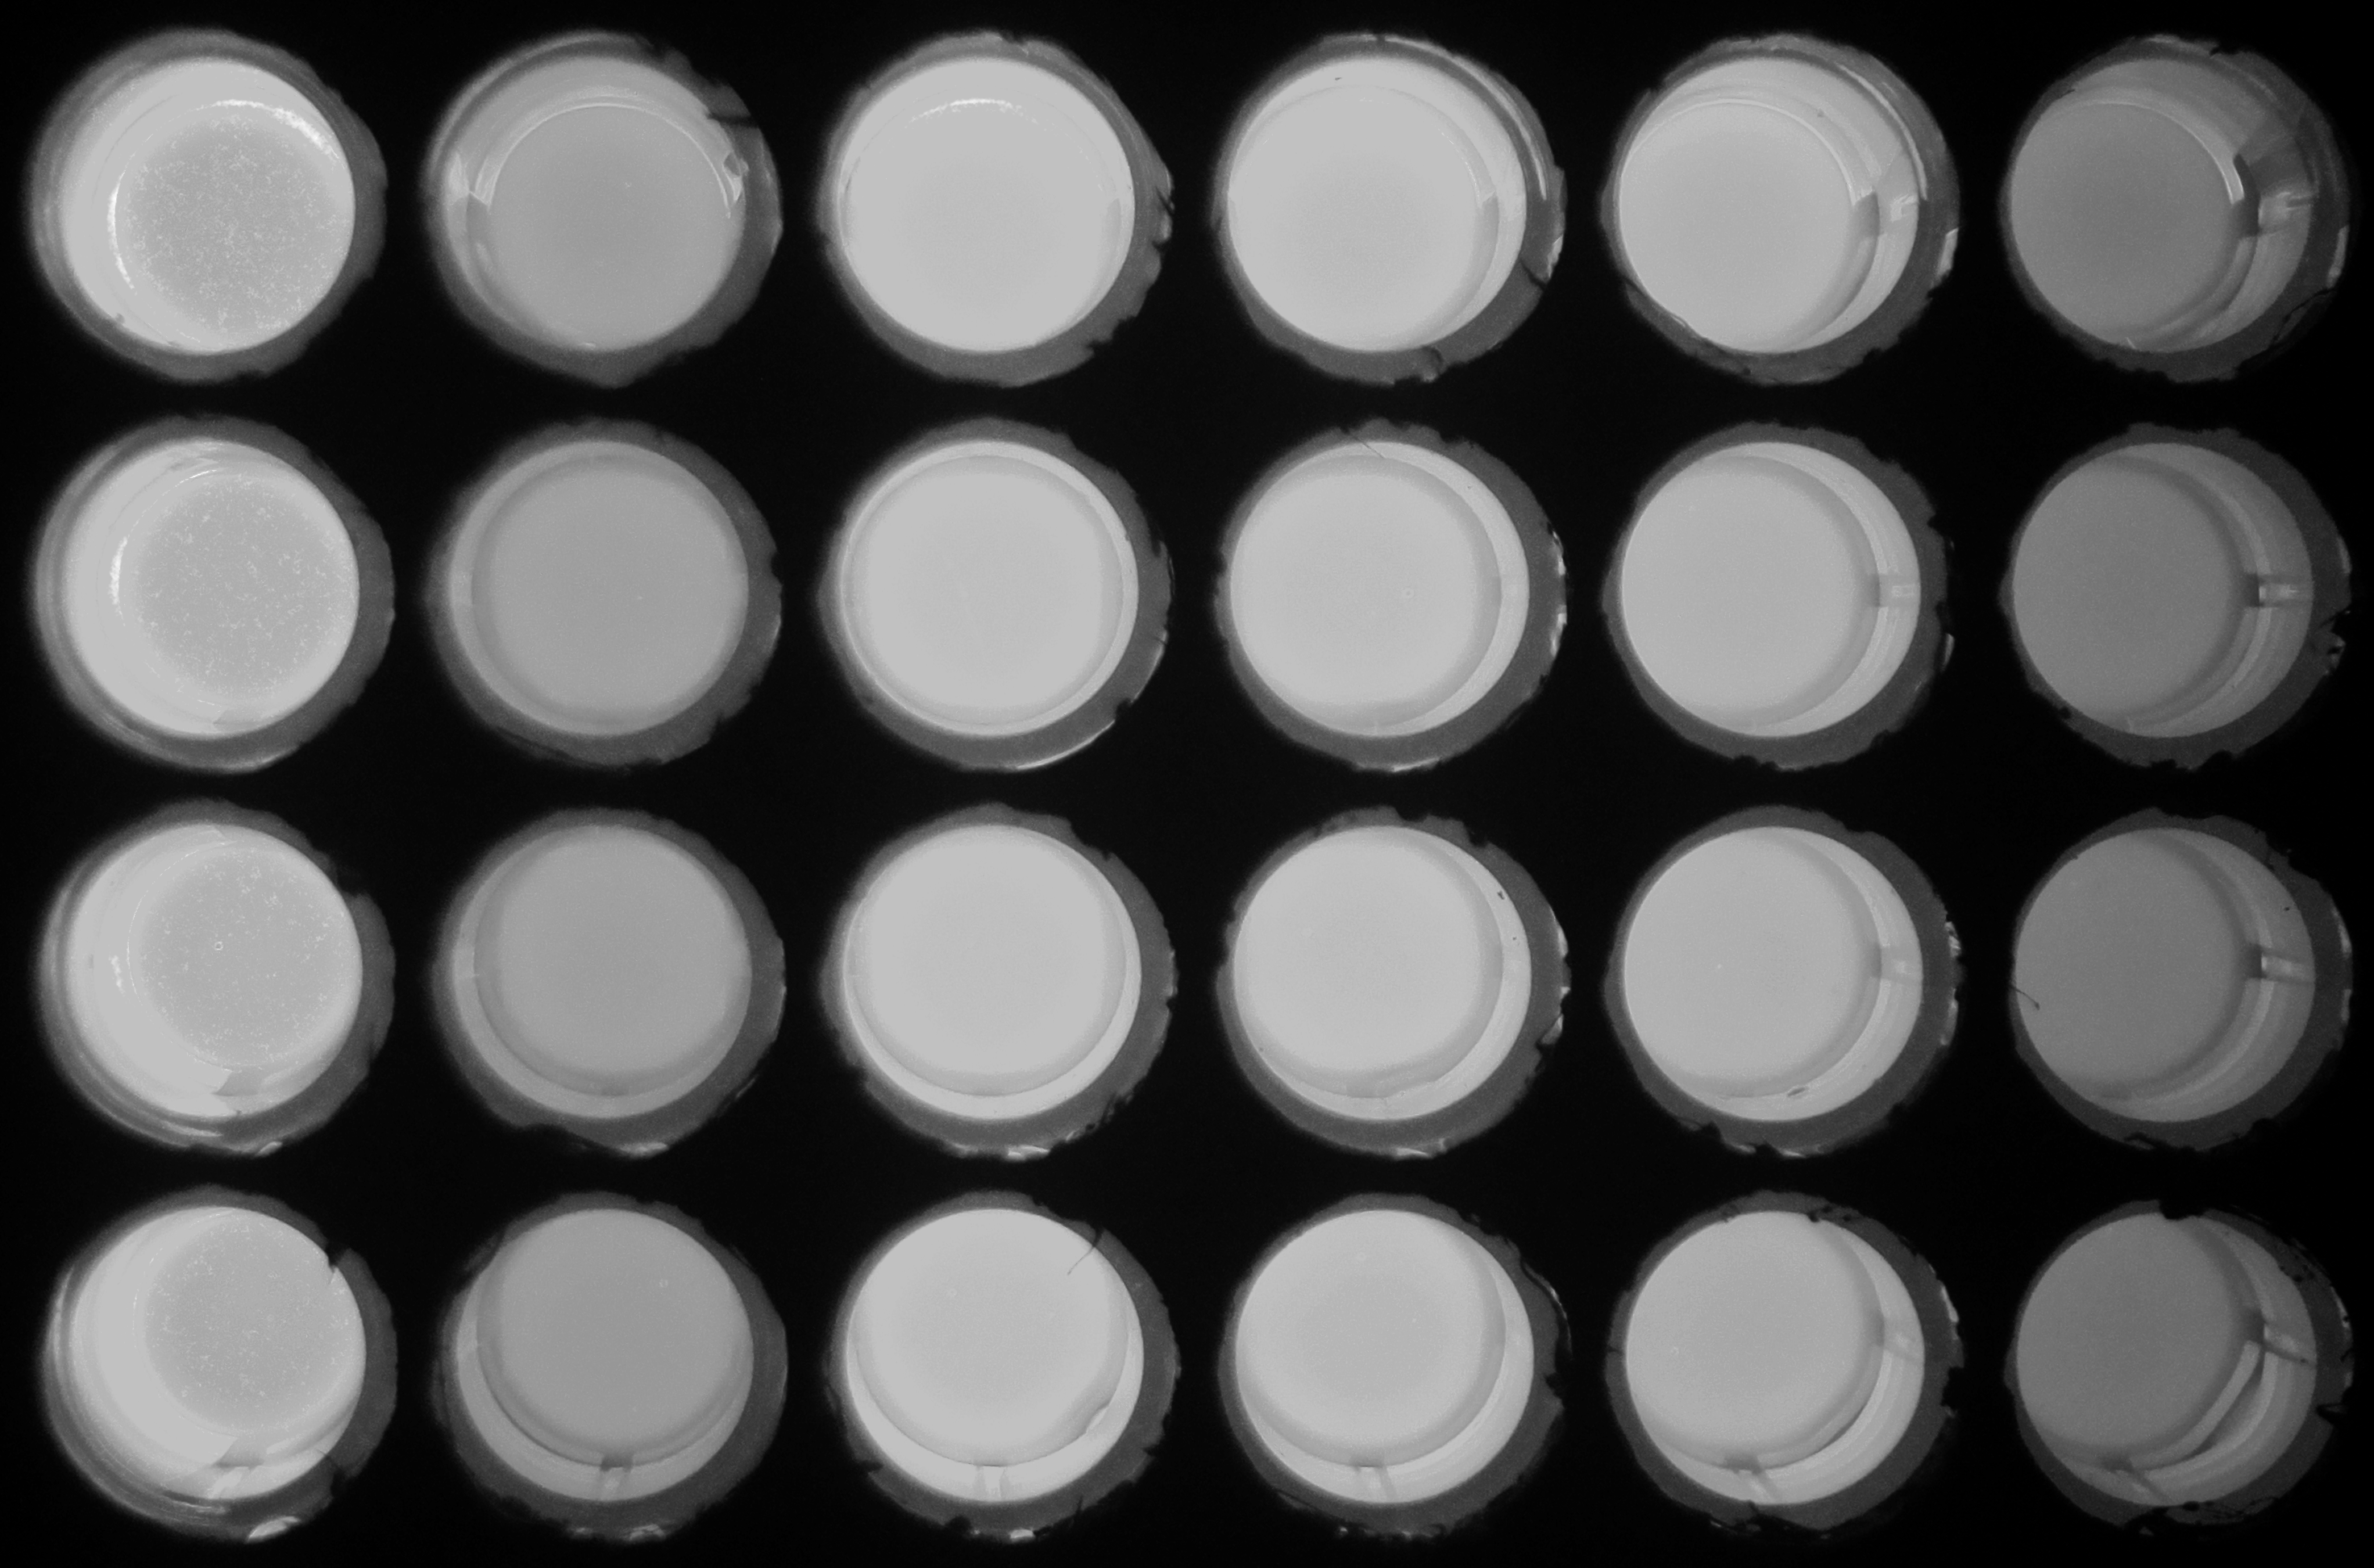

In [13]:
img = sample1
# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(img)

mask = img > threshold +7
mask = morphology.remove_small_objects(mask, 400)
mask = morphology.remove_small_holes(mask, 400)
labels = measure.label(mask)

fig = px.imshow(img, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(0, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)

### Mask Image Feature Extraction

In [14]:
from skimage.measure import label, regionprops, regionprops_table

props = regionprops_table(labels, properties=('centroid','area', 'eccentricity', 'perimeter','label'))
maskFeatures = pd.DataFrame(props)
maskFeatures.drop(maskFeatures.index[maskFeatures['area'] < 50000], inplace=True)

In [15]:
maskFeatures.head(10)

centroid-0   centroid-1    area  eccentricity    perimeter  label
0   243.988606  1218.725570  120417      0.182470  2195.902812      1
1   247.418262  1708.772625  116200      0.328230  2123.086579      2
3   253.943218   244.262221  115864      0.320750  1477.497654      4
4   249.746517   731.504535  111475      0.379673  1681.534234      5
5   250.823256  2194.485419  112513      0.322236  1562.237770      6
6   245.599293  2635.729306   72085      0.562539  1435.384956      7
12  731.334937   243.216597  120796      0.334205  1673.421536     13
13  729.732740  1220.979556  112602      0.197056  1361.213383     14
14  730.453144  1707.283158  110839      0.193727  1350.964646     15
15  729.539656   739.612502  108256      0.227253  1367.793073     16

In [16]:
x= maskFeatures['centroid-0'].tolist()
y =maskFeatures['centroid-1'].tolist()
area = maskFeatures['area'].tolist()

In [17]:
len(x)

24

## Create Induvidual Masks

In [18]:
from skimage.draw import ellipse
import math

maskList= []
coords = []
for i in range(0, len(x)):
    image = np.zeros((sample1.shape[0], sample1.shape[1]))
    radius = math.sqrt((area[i]/math.pi))
    rr, cc = ellipse(x[i], y[i],radius, radius)
    image[rr, cc] = 1
    maskList.append(image)
    masked = cv2.bitwise_and(sample1, sample1, mask=image.astype(np.uint8))
    mean = cv2.mean(masked, mask=masked)
    coords.append([(x[i], y[i]), mean[0]])

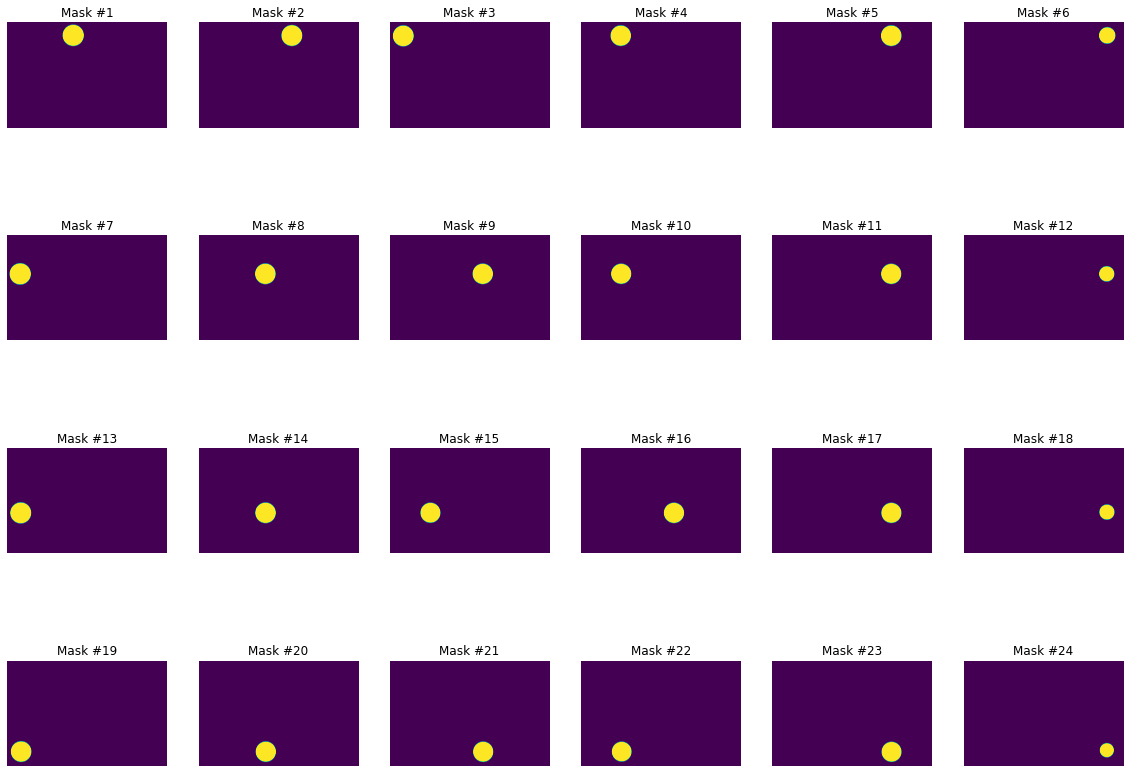

In [19]:
fig = plt.figure(figsize=(20,15))
  
# setting values to rows and column variables
rows = 4
columns = 6


for cnt,i in enumerate(maskList):
    fig.add_subplot(rows, columns, cnt+1)
    # showing image
    plt.imshow(i)
    plt.axis('off')
    plt.title(f"Mask #{cnt+1}")
  


In [20]:
coords.sort()
coords

[[(243.98860625991347, 1218.72557030984), 112.30648375739055],
 [(245.59929250190746, 2635.7293056807935), 72.9113003911994],
 [(247.41826161790019, 1708.7726247848536), 111.40092772681112],
 [(249.74651715631308, 731.5045346490244), 95.2148643193541],
 [(250.82325597930907, 2194.48541946264), 103.96722069149409],
 [(253.94321791065386, 244.26222122488434), 109.2565171604171],
 [(729.5396560005912, 739.6125018474727), 93.46104393929598],
 [(729.7327400934264, 1220.9795563133869), 113.23029307282415],
 [(730.4531437490414, 1707.2831584550565), 111.76066795373762],
 [(730.9090806940944, 2626.7952549882016), 71.90567461272975],
 [(731.0330147296486, 2194.111215773191), 103.42118385815864],
 [(731.3349365873042, 243.21659657604556), 107.7001514888122],
 [(1193.7890479153702, 2630.84310418236), 70.57581413625424],
 [(1205.483438626047, 744.2145444335252), 92.31211216457794],
 [(1206.9632332629365, 1224.6237246148225), 113.44626353549306],
 [(1207.7026728743137, 2197.312694761834), 102.73686

# Filled Wellplate

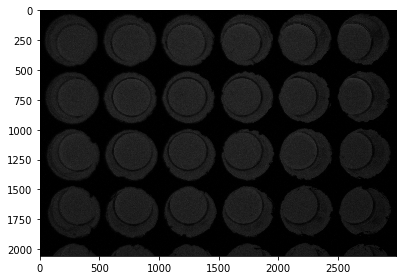

In [21]:
clear = cv2.imread('../input/dilution-test/dillution.png', cv2.IMREAD_GRAYSCALE)
matrix = cv2.getPerspectiveTransform(pts1,pts2)
clear_result = cv2.warpPerspective(clear, matrix, (2986,2057))
imshow(clear_result)

In [22]:
 def otsuMethod(sample):
    image = sample
    thresh = threshold_otsu(image)
    binary = image > thresh
    binary = morphology.remove_small_objects(binary, 400)
    binary = morphology.remove_small_holes(binary, 400)
    labels = measure.label(binary)
    fig, axes = plt.subplots(ncols=3, figsize=(16, 4.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')
    

    plt.show()
    return(labels)

In [23]:
def maskCreator(im,df):
    maskList= []
    coords = []
    x= df['centroid-0'].tolist()
    y =df['centroid-1'].tolist()
    area = df['area'].tolist()
    for i in range(0, len(x)):
        image = np.zeros((im.shape[0], im.shape[1]))
        radius = math.sqrt((area[i]/math.pi))
        rr, cc = ellipse(x[i], y[i],radius, radius)
        image[rr, cc] = 1
        maskList.append(image)
        masked = cv2.bitwise_and(im, im, mask=image.astype(np.uint8))
        mean = cv2.mean(masked, mask=masked)
        coords.append([(x[i], y[i]), mean[0]])
        coords.sort
    return(coords,maskList)

In [24]:
def wellplateCode(item):
    gammaIMG = adjust_gamma(item, gamma=0.7)
    imshow(gammaIMG)
    labels = otsuMethod(item)
    props = regionprops_table(labels, properties=('centroid','area', 'eccentricity', 'perimeter','label'))
    maskFeatures = pd.DataFrame(props)
    maskFeatures.drop(maskFeatures.index[maskFeatures['area'] < 50000], inplace=True)
    
    print(len(x))
    print(len(y))
    coords=maskCreator(gammaIMG,maskFeatures)

    return(coords)

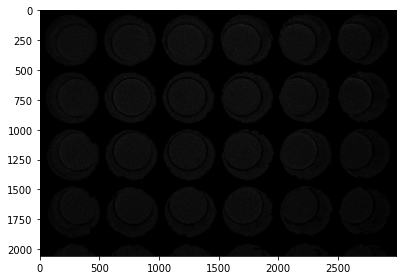

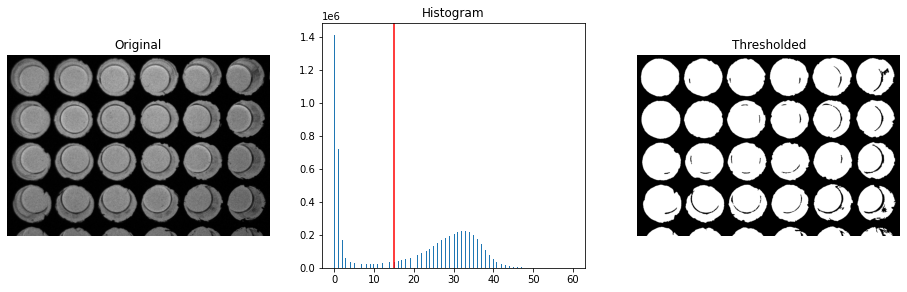

24
24


In [25]:
clearCoords, clearMasks=wellplateCode(clear_result)

In [26]:
clearCoords

[[(245.07627579475738, 2212.9186977133295), 12.033034311843346],
 [(242.03059559423443, 2698.5622488139484), 9.856784547886246],
 [(253.53949961773432, 1236.2209004636286), 13.859261237455373],
 [(249.37271916420636, 1724.357210517946), 13.746351060218762],
 [(254.15411718377584, 259.8524459919722), 11.266598852698374],
 [(254.79904551356285, 751.0499771905814), 12.93216482208148],
 [(726.57842746695, 2212.517041430595), 12.24276743498818],
 [(721.9312315138478, 2705.82025484748), 10.159081719753807],
 [(730.0621062674505, 1730.8256071724215), 13.467712657426299],
 [(733.0777674196918, 1240.9846077283783), 13.06110454980035],
 [(733.3255433318831, 756.3170558214377), 13.491392714732935],
 [(735.7102933506729, 268.9517945800229), 12.064336262751118],
 [(1202.816202109075, 2221.214168004583), 11.735095101356153],
 [(1200.3199002321642, 2709.9747835226203), 8.717285371853908],
 [(1209.6034143699947, 1249.2088166557414), 12.529929262657978],
 [(1206.9910465149728, 1735.3824468544142), 12.5

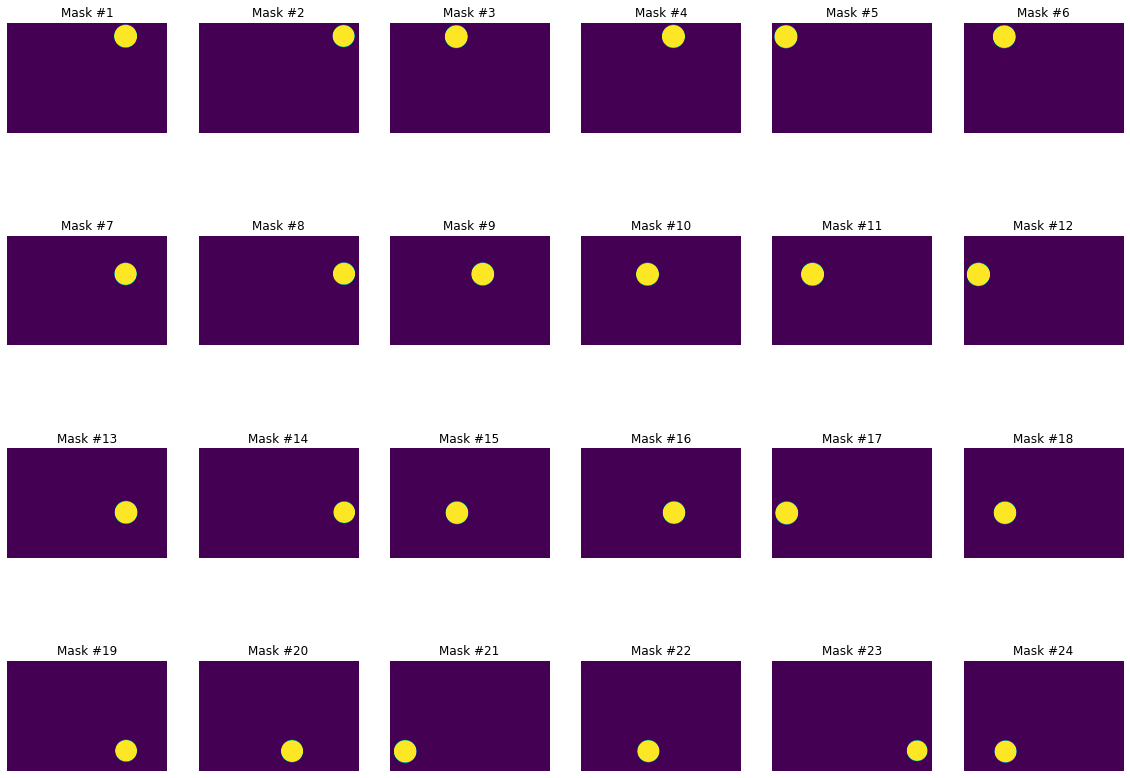

In [27]:
fig = plt.figure(figsize=(20,15))
  
# setting values to rows and column variables
rows = 4
columns = 6


for cnt,i in enumerate(clearMasks):
    fig.add_subplot(rows, columns, cnt+1)
    # showing image
    plt.imshow(i)
    plt.axis('off')
    plt.title(f"Mask #{cnt+1}")
  


In [28]:
postitions = ["A1","B1", "C1", "D1", "A2", "B2", "C2", "D2", "A3", "B3", "C3","D3", "A4","B4", "C4", "D4", "A5", "B5","C5","D5", "A6","B6", "C6", "D6"]

def flourenceValues(sampleCoords,clearCoords):
    slope = 19.5
    yIntercept = 36.6
    flourenceVals = [(slope*(sampleCoords[i][1]-clearCoords[i][1]))+yIntercept for i in range(len(postitions))]
    return(flourenceVals)

def odValues(sampleCoords,clearCoords):
    slope = 1.5
    yIntercept = .03635
    flourenceVals = [(slope(math.log10(clearCoords[i][1]/sampleCoords[i][1])))+yIntercept for i in range(len(postitions))]
    return(flourenceVals)

In [29]:
outputDict = {'position': postitions,'values':flourenceValues(coords,clearCoords) }
outputDf = pd.DataFrame(outputDict)
outputDf.head(24)
outputDf.set_index("position", inplace = True)
outputDf

values
position             
A1        1991.932264
B1        1266.163059
C1        1938.662497
D1        1625.236009
A2        1844.262126
B2        1914.924871
C2        1620.356392
D2        2046.488621
A3        1953.312628
B3        1184.069116
C3        1790.230927
D3        1901.498397
A4        1183.994021
B4        1666.699122
C4        2004.468518
D4        1795.518795
A5        1981.474455
B5        1904.119025
C5        1164.336189
D5        1900.974419
A6        1596.621883
B6        2031.088915
C6        2035.025744
D6        1767.305332